In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight # הוספנו את פונקציית המשקולות
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from scipy.stats import wilcoxon
from statsmodels.stats.contingency_tables import mcnemar




In [2]:
# ==========================================
# 1. System Settings and Parameters
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"🚀 Using device: {device}")

SEQ_LENGTH = 5  # Sequence length: The model will see 2.5 minutes at a time
BATCH_SIZE = 64
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# ==========================================
# 2. Data Loading (using the raw Train file)
# ==========================================
print("📂 Loading data...")
# Make sure this file exists in your directory
data = np.load('train_smote_final.npz') 
X_full = data['x'] # Expected structure: (Epochs, Time, Channels)
y_full = data['y']

# Split into train and validation (stratified split to preserve class ratio)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# ==========================================
# 3. Dataset Class (Sequence-based)
# ==========================================
class SleepSequenceDataset(Dataset):
    def __init__(self, x_data, y_data, seq_length=5):
        self.x = torch.from_numpy(x_data).float()
        self.y = torch.from_numpy(y_data).long()
        self.seq_length = seq_length

    def __len__(self):
        return len(self.y) - self.seq_length + 1

    def __getitem__(self, idx):
        # Extract a sequence of epochs
        x_seq = self.x[idx : idx + self.seq_length] 
        # The label is from the last epoch in the sequence
        y_label = self.y[idx + self.seq_length - 1]
        return x_seq, y_label

train_dataset = SleepSequenceDataset(X_train, y_train, seq_length=SEQ_LENGTH)
val_dataset = SleepSequenceDataset(X_val, y_val, seq_length=SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data Ready! Sequences: {len(train_dataset)}")

# ==========================================
# 4. Model Architecture (SleepNet Seq)
# ==========================================
class SleepNetSeq(nn.Module):
    def __init__(self, num_classes=5):
        super(SleepNetSeq, self).__init__()
        
        # Branch 1: The two EEG channels
        self.eeg_branch = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=50, stride=5), # 2 input channels
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(8)
        )
        
        # Branch 2: The single EOG channel
        self.eog_branch = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=50, stride=5), # 1 input channel
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(8)
        )
        
        # Combine features after splitting
        self.common_conv = nn.Sequential(
            nn.Conv1d(32 + 16, 64, kernel_size=8, stride=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        
        # Bidirectional GRU for temporal sequence processing
        self.gru = nn.GRU(64, 128, num_layers=2, batch_first=True, bidirectional=True)
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (Batch, Seq, Time, Chans)
        bs, seq, ts, ch = x.size()
        
        # Flatten Batch and Sequence for the CNN
        x = x.view(bs * seq, ts, ch).transpose(1, 2) # (BS*Seq, Chans, Time)
        
        # Split channels: assuming 0,1 are EEG and 2 is EOG
        eeg_input = x[:, 0:2, :] # Channels 0 and 1
        eog_input = x[:, 2:3, :] # Channel 2
        
        # Pass through the separate branches
        eeg_feat = self.eeg_branch(eeg_input)
        eog_feat = self.eog_branch(eog_input)
        
        # Concatenation of features
        combined_feat = torch.cat((eeg_feat, eog_feat), dim=1)
        
        # Shared processing
        x = self.common_conv(combined_feat)
        
        # Average over time (Global Average Pooling)
        x = torch.mean(x, dim=2) 
        
        # Reshape back to sequence structure (BS, Seq, Features)
        x = x.view(bs, seq, 64) 
        
        # GRU
        gru_out, _ = self.gru(x)
        
        # Take the last epoch in the sequence for classification
        out = self.fc(gru_out[:, -1, :])
        return out

# ==========================================
# 5. Loss Definition and Weights
# ==========================================
model = SleepNetSeq().to(device)

# Calculate weights to balance N1
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

🚀 Using device: mps
📂 Loading data...
✅ Data Ready! Sequences: 221216


In [3]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ==========================================
# 6. Training Loop
# ==========================================
print("\n" + "="*30)
print("🏃 Starting Sequence Training...")
print("="*30)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Acc: {100.*correct/total:.2f}% | Val Acc: {100.*val_correct/val_total:.2f}%")

torch.save(model.state_dict(), 'model_smote.pth')
print("\n🎉 Training Complete!")


🏃 Starting Sequence Training...
Epoch [1/15] | Train Acc: 78.55% | Val Acc: 80.05%
Epoch [2/15] | Train Acc: 82.95% | Val Acc: 83.43%
Epoch [3/15] | Train Acc: 84.02% | Val Acc: 83.71%
Epoch [4/15] | Train Acc: 84.76% | Val Acc: 82.21%
Epoch [5/15] | Train Acc: 85.47% | Val Acc: 85.01%
Epoch [6/15] | Train Acc: 85.93% | Val Acc: 85.76%
Epoch [7/15] | Train Acc: 86.46% | Val Acc: 86.27%
Epoch [8/15] | Train Acc: 86.82% | Val Acc: 85.53%
Epoch [9/15] | Train Acc: 87.16% | Val Acc: 86.35%
Epoch [10/15] | Train Acc: 87.55% | Val Acc: 86.08%
Epoch [11/15] | Train Acc: 87.91% | Val Acc: 83.90%
Epoch [12/15] | Train Acc: 88.30% | Val Acc: 86.48%
Epoch [13/15] | Train Acc: 88.72% | Val Acc: 86.15%
Epoch [14/15] | Train Acc: 89.08% | Val Acc: 86.56%
Epoch [15/15] | Train Acc: 89.49% | Val Acc: 86.72%

🎉 Training Complete!


🚀 Analyzing model in Many-to-One mode...
✅ Fixed! Labels: 1943, Predictions: 1943

📈 --- Classification Report (Many-to-One) ---
              precision    recall  f1-score   support

        Wake       0.97      0.94      0.95       682
          N1       0.51      0.62      0.56       179
          N2       0.90      0.78      0.84       676
          N3       0.72      0.91      0.80       126
         REM       0.75      0.86      0.80       280

    accuracy                           0.84      1943
   macro avg       0.77      0.82      0.79      1943
weighted avg       0.86      0.84      0.84      1943



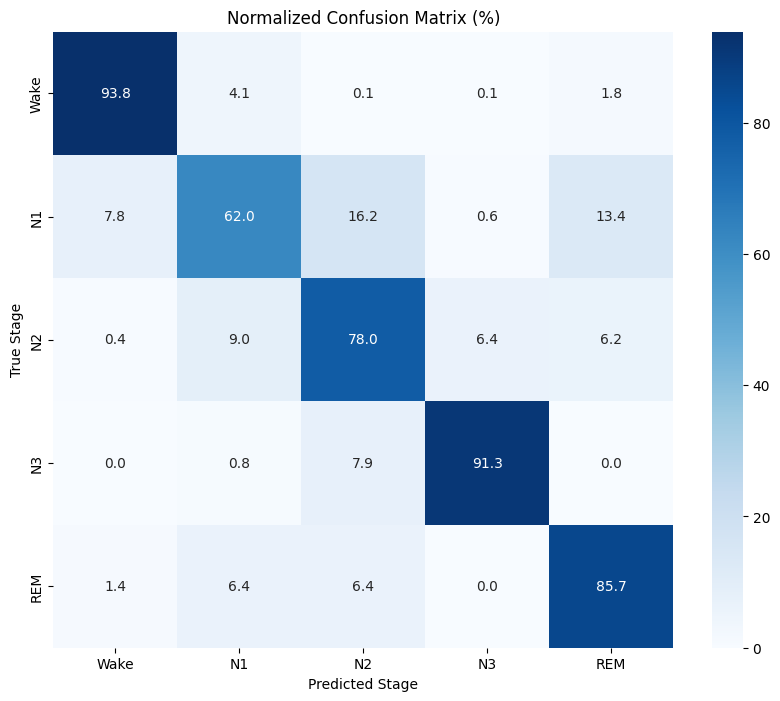

In [4]:
# --- Settings ---
SEQ_LEN = 20  # Must be identical to the sequence length used during training!
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available(): DEVICE = torch.device('mps')

# 1. Loading and shaping data into sequences
data = np.load('test_final.npz')
X_raw = data['x']  # (N, 3000, 3)
y_raw = data['y']  # (N,)

def create_sequences(X, y, seq_len):
    n_seq = len(X) // seq_len
    X_seq = X[:n_seq * seq_len].reshape(n_seq, seq_len, 3000, 3)
    y_seq = y[:n_seq * seq_len].reshape(n_seq, seq_len)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.long)

X_test_seq, y_test_seq = create_sequences(X_raw, y_raw, SEQ_LEN)
test_loader = DataLoader(TensorDataset(X_test_seq, y_test_seq), batch_size=32)

# 2. Running the model
model.to(DEVICE)
model.eval()
all_preds = []
all_labels = []

print("🚀 Analyzing model in Many-to-One mode...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs) # Output shape: (Batch, 5)
        
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        
        # Take only the last label from each sequence (index -1)
        # Original labels shape is (Batch, Seq_Len)
        last_label_in_seq = labels[:, -1] 
        all_labels.extend(last_label_in_seq.numpy())

print(f"✅ Fixed! Labels: {len(all_labels)}, Predictions: {len(all_preds)}")

# --- Results Report ---

stages = ['Wake', 'N1', 'N2', 'N3', 'REM']
unique_idx = np.unique(all_labels).astype(int)
target_names = [stages[i] for i in unique_idx]

print("\n📈 --- Classification Report (Many-to-One) ---")
print(classification_report(all_labels, all_preds, labels=unique_idx, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_idx)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(10, 8))
sns.heatmap(cm_perc, annot=True, fmt='.1f', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Stage')
plt.ylabel('True Stage')
plt.show()

אימון לפי oversampelling

In [5]:

# ==========================================
# 1. הגדרות מערכת ופרמטרים
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"🚀 Using device: {device}")

SEQ_LENGTH = 5  # אורך רצף: המודל יראה 2.5 דקות בכל פעם
BATCH_SIZE = 64
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# ==========================================
# 2. טעינת נתונים (שימוש בקובץ ה-Train הגולמי)
# ==========================================
print("📂 Loading data...")
# וודאי שהקובץ הזה קיים בתיקייה שלך
data = np.load('train_ros_final.npz') 
X_full = data['x'] # מבנה מצופה: (Epochs, Time, Channels)
y_full = data['y']

# חלוקה לאימון וולידציה (שמירה על יחס המחלקות)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# ==========================================
# 3. Dataset Class (Sequence-based)
# ==========================================
class SleepSequenceDataset(Dataset):
    def __init__(self, x_data, y_data, seq_length=5):
        self.x = torch.from_numpy(x_data).float()
        self.y = torch.from_numpy(y_data).long()
        self.seq_length = seq_length

    def __len__(self):
        return len(self.y) - self.seq_length + 1

    def __getitem__(self, idx):
        # שליפת רצף של אפוקים
        x_seq = self.x[idx : idx + self.seq_length] 
        # הלייבל הוא של האפוק האחרון ברצף
        y_label = self.y[idx + self.seq_length - 1]
        return x_seq, y_label

train_dataset = SleepSequenceDataset(X_train, y_train, seq_length=SEQ_LENGTH)
val_dataset = SleepSequenceDataset(X_val, y_val, seq_length=SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data Ready! Sequences: {len(train_dataset)}")

# ==========================================
# 4. ארכיטקטורת המודל (SleepNet Seq)
# ==========================================
class SleepNetSeq(nn.Module):
    def __init__(self, num_classes=5):
        super(SleepNetSeq, self).__init__()
        
        # ענף 1: שני ערוצי ה-EEG
        self.eeg_branch = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=50, stride=5), # 2 ערוצי כניסה
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(8)
        )
        
        # ענף 2: ערוץ ה-EOG הבודד
        self.eog_branch = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=50, stride=5), # ערוץ כניסה 1
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(8)
        )
        
        # שילוב התכונות לאחר הפיצול
        self.common_conv = nn.Sequential(
            nn.Conv1d(32 + 16, 64, kernel_size=8, stride=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        
        # GRU דו-כיווני לעיבוד הרצף הזמני
        self.gru = nn.GRU(64, 128, num_layers=2, batch_first=True, bidirectional=True)
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (Batch, Seq, Time, Chans)
        bs, seq, ts, ch = x.size()
        
        # משטיחים את ה-Batch וה-Sequence לצורך ה-CNN
        x = x.view(bs * seq, ts, ch).transpose(1, 2) # (BS*Seq, Chans, Time)
        
        # פיצול הערוצים: נניח ש-0,1 הם EEG ו-2 הוא EOG
        eeg_input = x[:, 0:2, :] # ערוצים 0 ו-1
        eog_input = x[:, 2:3, :] # ערוץ 2
        
        # העברה בענפים הנפרדים
        eeg_feat = self.eeg_branch(eeg_input)
        eog_feat = self.eog_branch(eog_input)
        
        # איחוד (Concatenation) של התכונות
        combined_feat = torch.cat((eeg_feat, eog_feat), dim=1)
        
        # עיבוד משותף
        x = self.common_conv(combined_feat)
        
        # ממוצע על פני הזמן (Global Average Pooling)
        x = torch.mean(x, dim=2) 
        
        # מחזירים למבנה רצף (BS, Seq, Features)
        x = x.view(bs, seq, 64) 
        
        # GRU
        gru_out, _ = self.gru(x)
        
        # לוקחים את האפוק האחרון ברצף לסיווג
        out = self.fc(gru_out[:, -1, :])
        return out

# ==========================================
# 5. הגדרת אובדן (Loss) ומשקולות
# ==========================================
model = SleepNetSeq().to(device)

# חישוב משקולות לאיזון ה-N1
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ==========================================
# 6. לולאת אימון
# ==========================================
print("\n" + "="*30)
print("🏃 Starting Sequence Training...")
print("="*30)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Acc: {100.*correct/total:.2f}% | Val Acc: {100.*val_correct/val_total:.2f}%")

torch.save(model.state_dict(), 'model_ros.pth')
print("\n🎉 Training Complete!")

🚀 Using device: mps
📂 Loading data...
✅ Data Ready! Sequences: 221216

🏃 Starting Sequence Training...
Epoch [1/15] | Train Acc: 75.21% | Val Acc: 79.47%
Epoch [2/15] | Train Acc: 79.51% | Val Acc: 80.81%
Epoch [3/15] | Train Acc: 80.77% | Val Acc: 81.19%
Epoch [4/15] | Train Acc: 81.65% | Val Acc: 80.84%
Epoch [5/15] | Train Acc: 82.50% | Val Acc: 81.91%
Epoch [6/15] | Train Acc: 83.13% | Val Acc: 82.75%
Epoch [7/15] | Train Acc: 83.76% | Val Acc: 82.47%
Epoch [8/15] | Train Acc: 84.24% | Val Acc: 83.41%
Epoch [9/15] | Train Acc: 84.77% | Val Acc: 82.22%
Epoch [10/15] | Train Acc: 85.21% | Val Acc: 84.05%
Epoch [11/15] | Train Acc: 85.80% | Val Acc: 80.62%
Epoch [12/15] | Train Acc: 86.33% | Val Acc: 84.30%
Epoch [13/15] | Train Acc: 86.86% | Val Acc: 84.41%
Epoch [14/15] | Train Acc: 87.22% | Val Acc: 83.89%
Epoch [15/15] | Train Acc: 87.80% | Val Acc: 84.35%

🎉 Training Complete!


🚀 Analyzing model in Many-to-One mode...
✅ Fixed! Labels: 1943, Predictions: 1943

📈 --- Classification Report (Many-to-One) ---
              precision    recall  f1-score   support

        Wake       0.98      0.90      0.94       682
          N1       0.45      0.65      0.53       179
          N2       0.90      0.80      0.85       676
          N3       0.71      0.94      0.81       126
         REM       0.83      0.84      0.83       280

    accuracy                           0.84      1943
   macro avg       0.77      0.83      0.79      1943
weighted avg       0.86      0.84      0.85      1943



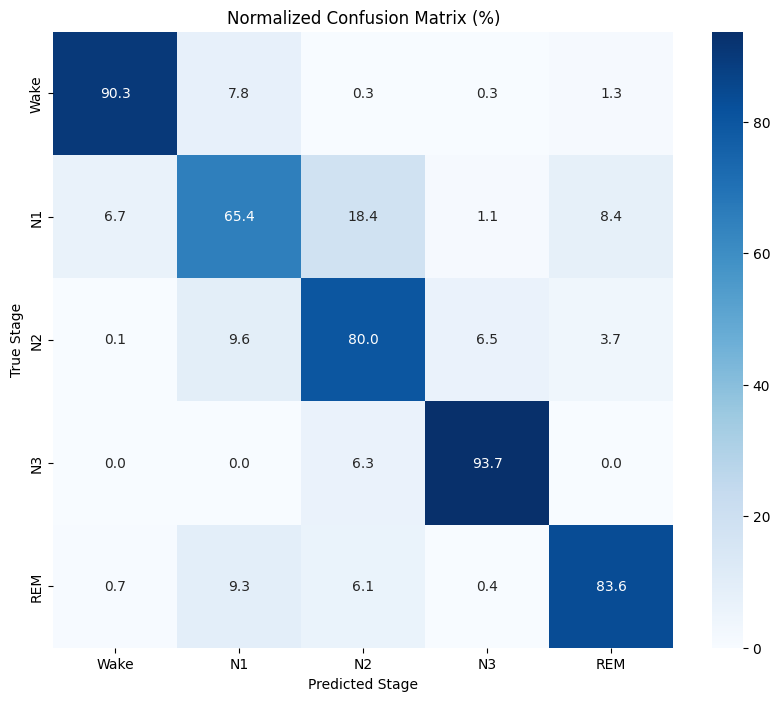

In [6]:
# --- הגדרות ---
SEQ_LEN = 20  # חייב להיות זהה למה שהיה באימון!
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available(): DEVICE = torch.device('mps')

# 1. טעינה וסידור הנתונים לרצפים (Sequences)
data = np.load('test_final.npz')
X_raw = data['x']  # (N, 3000, 3)
y_raw = data['y']  # (N,)

def create_sequences(X, y, seq_len):
    n_seq = len(X) // seq_len
    X_seq = X[:n_seq * seq_len].reshape(n_seq, seq_len, 3000, 3)
    y_seq = y[:n_seq * seq_len].reshape(n_seq, seq_len)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.long)

X_test_seq, y_test_seq = create_sequences(X_raw, y_raw, SEQ_LEN)
model = SleepNetSeq()
weights_path = 'model_ros.pth'  # או 'model_ros.pth' תלוי את מי את בודקת
model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
test_loader = DataLoader(TensorDataset(X_test_seq, y_test_seq), batch_size=32)

# 2. הרצת המודל
model.to(DEVICE)
model.eval()
all_preds = []
all_labels = []

model.eval()
print("🚀 Analyzing model in Many-to-One mode...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs) # פלט: (Batch, 5)
        
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        
        # לוקחים רק את הלייבל האחרון מכל רצף (index -1)
        # labels המקורי הוא (Batch, Seq_Len)
        last_label_in_seq = labels[:, -1] 
        all_labels.extend(last_label_in_seq.numpy())

print(f"✅ Fixed! Labels: {len(all_labels)}, Predictions: {len(all_preds)}")


stages = ['Wake', 'N1', 'N2', 'N3', 'REM']
unique_idx = np.unique(all_labels).astype(int)
target_names = [stages[i] for i in unique_idx]

print("\n📈 --- Classification Report (Many-to-One) ---")
print(classification_report(all_labels, all_preds, labels=unique_idx, target_names=target_names))

# מטריצת בלבול
cm = confusion_matrix(all_labels, all_preds, labels=unique_idx)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(10, 8))
sns.heatmap(cm_perc, annot=True, fmt='.1f', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Stage')
plt.ylabel('True Stage')
plt.show()

In [10]:

# ==========================================
# הגדרות בסיס וטעינת הנתונים (כדי למנוע שגיאות NameError)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LENGTH = 5
BATCH_SIZE = 64

print("📂 Loading Test Data from file...")
test_data = np.load('test_final.npz')
X_test, y_test = test_data['x'], test_data['y']

# ==========================================
# 0. יצירת ה-Test Loader 
# ==========================================
print("📦 Creating Test DataLoader...")
test_dataset = SleepSequenceDataset(X_test, y_test, seq_length=SEQ_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 1. הכנת משתנים וטעינת מודלים
# ==========================================
y_true = []
preds_smote = []
preds_ros = []

print("🔄 Loading models for comparison...")
m_smote = SleepNetSeq().to(device)
m_smote.load_state_dict(torch.load('model_smote.pth', map_location=device))
m_smote.eval()

m_ros = SleepNetSeq().to(device)
m_ros.load_state_dict(torch.load('model_ros.pth', map_location=device))
m_ros.eval()

# ==========================================
# 2. יצירת תחזיות
# ==========================================
print("🧠 Generating predictions on the Test Set...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        
        # הרשימה של התוויות האמיתיות
        y_true.extend(labels.cpu().numpy())
        
        # תחזיות מודל SMOTE
        out_smote = m_smote(inputs)
        _, p_smote = torch.max(out_smote, 1)
        preds_smote.extend(p_smote.cpu().numpy())
        
        # תחזיות מודל ROS
        out_ros = m_ros(inputs)
        _, p_ros = torch.max(out_ros, 1)
        preds_ros.extend(p_ros.cpu().numpy())

print("✅ Predictions complete. Running McNemar's Test...")

# ==========================================
# 3. מבחן מקנמר - בניית הטבלה וחישוב
# ==========================================
both_correct = 0
smote_correct_ros_wrong = 0
ros_correct_smote_wrong = 0
both_wrong = 0

for t, p_s, p_r in zip(y_true, preds_smote, preds_ros):
    s_correct = (p_s == t)
    r_correct = (p_r == t)
    
    if s_correct and r_correct:
        both_correct += 1
    elif s_correct and not r_correct:
        smote_correct_ros_wrong += 1
    elif not s_correct and r_correct:
        ros_correct_smote_wrong += 1
    else:
        both_wrong += 1

table = [[both_correct, smote_correct_ros_wrong],
         [ros_correct_smote_wrong, both_wrong]]

print("\n📊 --- McNemar's Test Contingency Table ---")
print(f"Both models correct: {both_correct}")
print(f"Both models wrong: {both_wrong}")
print(f"SMOTE correct, ROS wrong: {smote_correct_ros_wrong}")
print(f"ROS correct, SMOTE wrong: {ros_correct_smote_wrong}")

# חישוב P-Value
result = mcnemar(table, exact=False, correction=True)

print(f"\n📈 McNemar's Test P-Value: {result.pvalue:.5f}")

if result.pvalue < 0.05:
    print("✅ Conclusion: The difference in predictive performance between the models is statistically significant!")
else:
    print("⚠️ Conclusion: No statistically significant difference between the models.")

📂 Loading Test Data from file...
📦 Creating Test DataLoader...
🔄 Loading models for comparison...
🧠 Generating predictions on the Test Set...
✅ Predictions complete. Running McNemar's Test...

📊 --- McNemar's Test Contingency Table ---
Both models correct: 29409
Both models wrong: 4635
SMOTE correct, ROS wrong: 2422
ROS correct, SMOTE wrong: 2390

📈 McNemar's Test P-Value: 0.65496
⚠️ Conclusion: No statistically significant difference between the models.


🔄 טוען מודל לבדיקה: model_smote.pth
   ✅ מקטע 1/10: F1 = 0.8077
   ✅ מקטע 2/10: F1 = 0.8060
   ✅ מקטע 3/10: F1 = 0.8095
   ✅ מקטע 4/10: F1 = 0.8103
   ✅ מקטע 5/10: F1 = 0.8130
   ✅ מקטע 6/10: F1 = 0.8126
   ✅ מקטע 7/10: F1 = 0.8117
   ✅ מקטע 8/10: F1 = 0.8192
   ✅ מקטע 9/10: F1 = 0.8105
   ✅ מקטע 10/10: F1 = 0.8064
🔄 טוען מודל לבדיקה: model_ros.pth
   ✅ מקטע 1/10: F1 = 0.8422
   ✅ מקטע 2/10: F1 = 0.8439
   ✅ מקטע 3/10: F1 = 0.8507
   ✅ מקטע 4/10: F1 = 0.8381
   ✅ מקטע 5/10: F1 = 0.8416
   ✅ מקטע 6/10: F1 = 0.8455
   ✅ מקטע 7/10: F1 = 0.8456
   ✅ מקטע 8/10: F1 = 0.8453
   ✅ מקטע 9/10: F1 = 0.8374
   ✅ מקטע 10/10: F1 = 0.8407

📊 תוצאות המבחן הסטטיסטי למאמר
SMOTE (Mean F1): 0.8107
ROS (Mean F1):   0.8431
📊 P-Value לטובת ROS: 0.00098

✅ המסקנה: ההבדל מובהק! ROS עדיף על SMOTE באופן משמעותי.


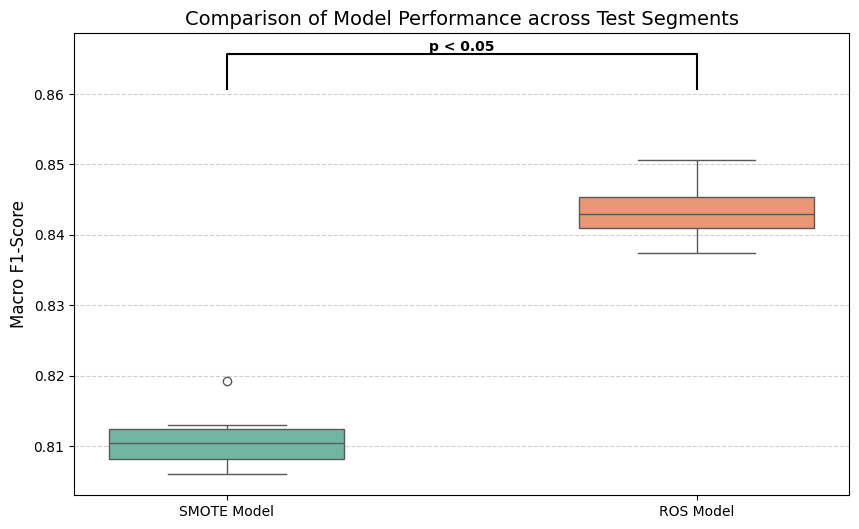

In [8]:

# --- 1. פונקציית הערכה נקייה (Sliding Window) ---
def evaluate_model_on_chunks(model_path, X_data, y_data, n_chunks=10, seq_len=5): # שימי לב ל-seq_len=5 לפי הקוד שלך
    print(f"🔄 טוען מודל לבדיקה: {model_path}")
    m = SleepNetSeq().to(device) # ודאי שזה device או DEVICE לפי מה שהגדרת
    m.load_state_dict(torch.load(model_path, map_location=device))
    m.eval()
    
    chunk_size = len(X_data) // n_chunks
    chunk_scores = []
    
    with torch.no_grad():
        for i in range(n_chunks):
            start = i * chunk_size
            end = (i + 1) * chunk_size
            
            X_chunk = X_data[start:end]
            y_chunk = y_data[start:end]
            
            preds, labels = [], []
            for j in range(len(X_chunk) - seq_len + 1):
                # אם הנתונים הם Numpy, נהפוך אותם ל-Tensor כאן
                if isinstance(X_chunk, np.ndarray):
                    window = torch.from_numpy(X_chunk[j:j+seq_len]).float().unsqueeze(0).to(device)
                else:
                    window = X_chunk[j:j+seq_len].clone().detach().float().unsqueeze(0).to(device)
                
                output = m(window)
                _, p = torch.max(output, 1)
                preds.append(p.item())
                
                # טיפול בתווית (Label)
                label = y_chunk[j+seq_len-1]
                labels.append(label.item() if torch.is_tensor(label) else label)
            
            score = f1_score(labels, preds, average='macro')
            chunk_scores.append(score)
            print(f"   ✅ מקטע {i+1}/{n_chunks}: F1 = {score:.4f}")
            
    return chunk_scores

f1_smote_list = evaluate_model_on_chunks('model_smote.pth', X_val, y_val)
f1_ros_list = evaluate_model_on_chunks('model_ros.pth', X_val, y_val)
# --- 3. מבחן סטטיסטי Wilcoxon (חד-צדדי לטובת ROS) ---
# אנחנו בודקים האם ROS גדול מ-SMOTE באופן מובהק
stat, p_val = wilcoxon(f1_ros_list, f1_smote_list, alternative='greater')
# --- 4. הצגת תוצאות סופיות ---
print("\n" + "="*40)
print("📊 תוצאות המבחן הסטטיסטי למאמר")
print("="*40)
print(f"SMOTE (Mean F1): {np.mean(f1_smote_list):.4f}")
print(f"ROS (Mean F1):   {np.mean(f1_ros_list):.4f}")
print(f"📊 P-Value לטובת ROS: {p_val:.5f}")

if p_val < 0.05:
    print("\n✅ המסקנה: ההבדל מובהק! ROS עדיף על SMOTE באופן משמעותי.")
else:
    print("\n⚠️ המסקנה: אין הבדל מובהק סטטיסטית.")

# --- 5. ויזואליזציה למאמר (Boxplot) ---
plt.figure(figsize=(10, 6))
data_to_plot = [f1_smote_list, f1_ros_list]
sns.boxplot(data=data_to_plot, palette="Set2", width=0.5)
plt.xticks([0, 1], ['SMOTE Model', 'ROS Model'])
plt.title('Comparison of Model Performance across Test Segments', fontsize=14)
plt.ylabel('Macro F1-Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# הוספת סימון מובהקות מעל הגרף אם p < 0.05
if p_val < 0.05:
    x1, x2 = 0, 1
    y, h, col = max(max(f1_smote_list), max(f1_ros_list)) + 0.01, 0.005, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, "p < 0.05", ha='center', va='bottom', color=col, weight='bold')

plt.show()

✅ חולצו 55301 אפוקים מסט הוולידציה.
📊 מייצר את Figure 1 (פיזיולוגיה)...


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_27845/602775042.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Pz-Oz (Occipital)', 'Fpz-Cz (Frontal)'])
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_27845/602775042.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Fpz-Cz (Frontal)', 'Pz-Oz (Occipital)'])
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_27845/602775042.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['REM', 'N3'])


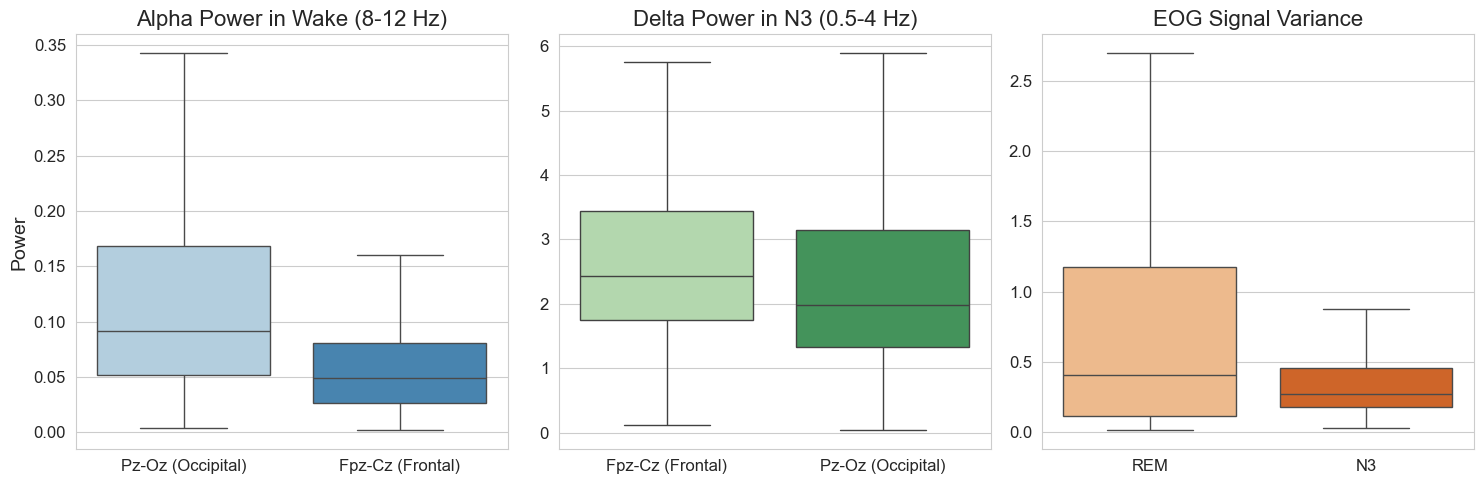

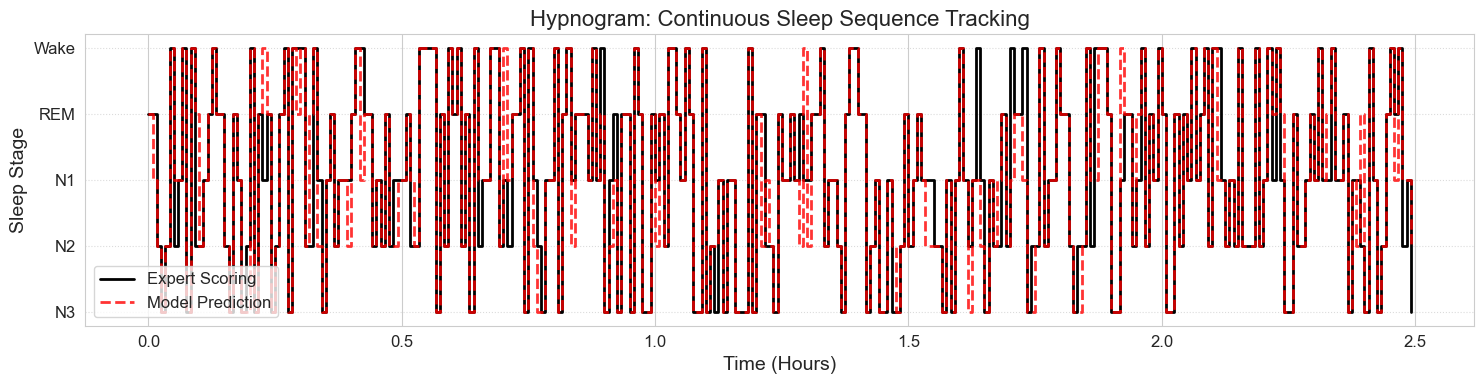

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from scipy.signal import welch
import scipy.stats as stats

# ==========================================
# 0. הגדרות עיצוב כלליות
# ==========================================
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16})
sns.set_style("whitegrid")
sleep_stages = ['W', 'N1', 'N2', 'N3', 'REM']
SAMPLING_RATE = 100  # 3000 דגימות ב-30 שניות = 100Hz

# ==========================================
# 1. חילוץ y_true ו-y_pred אמיתיים מהמודל (ROS)
# ==========================================
model_ros = SleepNetSeq().to(device)
model_ros.load_state_dict(torch.load('model_ros.pth', map_location=device))
model_ros.eval()

y_true_real = []
y_pred_real = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_ros(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true_real.extend(labels.cpu().numpy())
        y_pred_real.extend(preds.cpu().numpy())

y_true_real = np.array(y_true_real)
y_pred_real = np.array(y_pred_real)
print(f"✅ חולצו {len(y_true_real)} אפוקים מסט הוולידציה.")

# ==========================================
# Figure 1: תיקוף פיזיולוגי (מהנתונים הגולמיים X_val)
# ==========================================
def plot_physiological_validation(X_data, y_data):
    print("📊 מייצר את Figure 1 (פיזיולוגיה)...")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # חיפוש אינדקסים לפי שלבים (0=W, 3=N3, 4=REM)
    idx_w = np.where(y_data == 0)[0]
    idx_n3 = np.where(y_data == 3)[0]
    idx_rem = np.where(y_data == 4)[0]
    
    # לקיחת מדגם מייצג (עד 500 אפוקים כדי לא להעמיס על הזיכרון בחישוב תדרים)
    idx_w = np.random.choice(idx_w, min(500, len(idx_w)), replace=False)
    idx_n3 = np.random.choice(idx_n3, min(500, len(idx_n3)), replace=False)
    idx_rem = np.random.choice(idx_rem, min(500, len(idx_rem)), replace=False)

    # פונקציית עזר לחישוב כוח (Power) בתדר מסוים
    def get_band_power(data_indices, channel, fmin, fmax):
        powers = []
        for i in data_indices:
            signal = X_data[i, :, channel]
            freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=256)
            band_power = np.sum(psd[(freqs >= fmin) & (freqs <= fmax)])
            powers.append(band_power)
        return np.array(powers)

    # נניח שהערוצים הם: 0=Fpz-Cz, 1=Pz-Oz, 2=EOG
    alpha_fpz = get_band_power(idx_w, 0, 8, 12)
    alpha_pz = get_band_power(idx_w, 1, 8, 12)
    
    delta_fpz = get_band_power(idx_n3, 0, 0.5, 4)
    delta_pz = get_band_power(idx_n3, 1, 0.5, 4)
    
    # שונות EOG (ערוץ 2)
    eog_rem = np.var(X_data[idx_rem, :, 2], axis=1)
    eog_n3 = np.var(X_data[idx_n3, :, 2], axis=1)

    # Subplot A: Alpha
    sns.boxplot(data=[alpha_pz, alpha_fpz], ax=axes[0], palette="Blues", showfliers=False)
    axes[0].set_xticklabels(['Pz-Oz (Occipital)', 'Fpz-Cz (Frontal)'])
    axes[0].set_title('Alpha Power in Wake (8-12 Hz)')
    axes[0].set_ylabel('Power')

    # Subplot B: Delta
    sns.boxplot(data=[delta_fpz, delta_pz], ax=axes[1], palette="Greens", showfliers=False)
    axes[1].set_xticklabels(['Fpz-Cz (Frontal)', 'Pz-Oz (Occipital)'])
    axes[1].set_title('Delta Power in N3 (0.5-4 Hz)')

    # Subplot C: EOG
    sns.boxplot(data=[eog_rem, eog_n3], ax=axes[2], palette="Oranges", showfliers=False)
    axes[2].set_xticklabels(['REM', 'N3'])
    axes[2].set_title('EOG Signal Variance')

    plt.tight_layout()
    plt.savefig('fig1_physiological.pdf', dpi=300)
    plt.show()

# ==========================================
# Figure 5: היפנוגרמה (2.5 שעות ראשונות של סט הוולידציה)
# ==========================================
def plot_hypnogram(y_t, y_p, epochs_to_show=300):
    plt.figure(figsize=(15, 4))
    
    y_t_seg = y_t[:epochs_to_show]
    y_p_seg = y_p[:epochs_to_show]
    time_axis = np.arange(epochs_to_show) / 120 # המרה לשעות
    
    display_map = {0: 0, 4: -1, 1: -2, 2: -3, 3: -4} 
    true_disp = [display_map[v] for v in y_t_seg]
    pred_disp = [display_map[v] for v in y_p_seg]

    plt.step(time_axis, true_disp, label='Expert Scoring', color='black', linewidth=2, where='post')
    plt.step(time_axis, pred_disp, label='Model Prediction', color='red', linestyle='--', linewidth=2, alpha=0.8, where='post')

    plt.yticks([-4, -3, -2, -1, 0], ['N3', 'N2', 'N1', 'REM', 'Wake'])
    plt.xlabel('Time (Hours)')
    plt.ylabel('Sleep Stage')
    plt.title('Hypnogram: Continuous Sleep Sequence Tracking')
    plt.legend(loc='lower left')
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('fig5_hypnogram.pdf', dpi=300)
    plt.show()

# ==========================================
# הפעלת כל הפונקציות בשרשרת
# ==========================================
plot_physiological_validation(X_val, y_val) # מחשב תדרים ישירות מ-X_val האמיתי
plot_hypnogram(y_true_real, y_pred_real, epochs_to_show=300) # מצייר היפנוגרמה
